<a href="https://colab.research.google.com/github/seungmei/ESAA_24_1/blob/main/0510%EA%B8%88%EA%B3%BC%EC%A0%9C_Ch9_5_%EC%BD%98%ED%85%90%EC%B8%A0_%EA%B8%B0%EB%B0%98_%ED%95%84%ED%84%B0%EB%A7%81_%EC%8B%A4%EC%8A%B5_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0510금과제 Ch9 5. 콘텐츠 기반 필터링 실습 579pg~ 590pg

## 5. 콘텐츠 기반 필터링 실습

### 장르 속성을 이용한 영화 콘텐츠 기반 필터링
- 콘텐츠 기반 필터링: 사용자가 특정 영화를 감상하고 그 영화를 좋아했다면 그 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천.
e.g. 인셉션 호 ~> 비슷 장르인 액션, 공상과학 영화 추천 or 인셉션의 감독의 다른 작품 추천


### 데이터 로딩 및 가공

In [7]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv('/content/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp...",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, ...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporatio...","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United ...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [8]:
# 콘텐츠 기반 필터링 추천 분석에 사용할 주요 칼럼만 추출해 새롭게 df로 만들자.
movies_df = movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity',
                    'keywords', 'overview']]

In [9]:
'''
파이썬 list 내부에 여러 개의 딕셔너리가 있는 형태의 문자열로 표기돼 있음. 이는 한꺼번에 여러 개의 값을 표현하기 위한 표기 방식.
e.g. 아바타의 장르는 action이면서 adventure일 수 있음.
하지만, df로 만들어질 때는 단순히 문자열 형태로 로딩되므로 이 칼럼을 가공하지 않고는 필요한 정보를 추출할 수가 없음.
'''
# 해당 칼럼이 어떤 형태로 돼 있는지 확인해보자

pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

'''
genre 칼럼은 여러 개의 개별 장르 데이터를 가지고 있음. 이 개별 장르의 명칭은 딕셔너리의 key인 'name'으로 추출할 수 있음.
keywords 역시 마찬가지 구조
'''

"\ngenre 칼럼은 여러 개의 개별 장르 데이터를 가지고 있음. 이 개별 장르의 명칭은 딕셔너리의 key인 'name'으로 추출할 수 있음. \nkeywords 역시 마찬가지 구조\n"

In [10]:
# genres 칼럼의 문자열을 분해해서 개별 장르를 파이썬 리스트 객체로 추출해보기  - literal_eval() 함수 이용하여 list[dict1, dict2] 객체로 만들기

from ast import literal_eval
movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

## genres 칼럼은 not 문자열, but 실제 리스트 내부에 여러 장르 딕셔너리 구성 객체

In [11]:
# genres 칼럼에서 장르명만 리스트 객체로 추출.
movies_df['genres'] = movies_df['genres'].apply(lambda x: [y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x: [y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


### 장르 콘텐츠 유사도 측정
- genres를 문자열로 변경 ~> CountVectorizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교

In [12]:
# genres 칼럼을 문자열로 변환한 뒤 사이킷런의 CountVectorizer를 이용해 피처 벡터 행렬로 만들기.
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word단위가 구분되는 문자열로 변환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x: ('').join(x)) # 개별 요소를 공백 문자로 구분하는 문자열로 변환해('구분문자') 별도의 칼럼인 genres_listeral 칼럼으로 저장(.join(x))
count_vect = CountVectorizer(min_df=0, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)
## 피처 벡터 행렬 만들어짐.

(4803, 1394)


- 코사인 유사도 함수
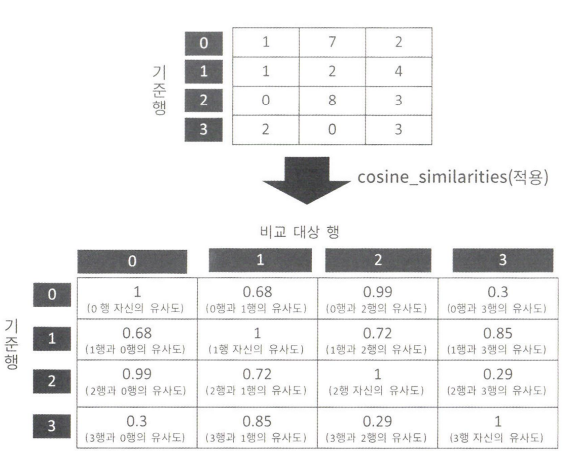

In [13]:
# 피처 벡터화된 행렬에 cosine_similarities() 적용
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:1])

(4803, 4803)
[[1. 0. 0. ... 0. 0. 0.]]


In [19]:
''' 장르 유사도가 높은 순으로 레코드 추출
genre_sim 객체 기준 행별로 비교 대상이 되는 행의 유사도 값이 높은 순으로 정렬된 행렬의 위치 인덱스 값 추출 '''
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])
## 반환된 값의 의미: 0번 레코드의 경우 자신 제외하면 870번 레코드가 가장 유사도 높 -> 그 다음 46번 ...

[[   0  870   46 ... 3172 3173 2401]]


### 장르 콘텐츠 필터링을 이용한 영화 추천
- 장르 유사도에 따라 영화를 추천하는 함수 생성

In [15]:
# 장르 유사도에 따라 영화를 추천하는 함수 생성
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  # 인자로 입력된 movies_df df에서 title 칼럼이 입력된 title_name값인 df 추출
  title_movie = df[df['title'] == title_name]

  #title_named을 가진 df의 idx 객체를 ndarray로 반환 후
  #sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 idx 추출
  title_index = title_movie.index.values
  similar_indexes = sorted_ind[title_index, :(top_n)]

  #추출된 top_n idx 출력. top_n idx는 2차원 데이터.
  #df에서 idx로 사용하기 위해서 1차원 array로 변경.
  print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

In [20]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', top_n=10)
similar_movies[['title', 'vote_average']]
## 평점이 0인 영화도 있으므로 개선이 필요

[[3636  883 1149 3337 1464 1243 1847 3866 2582 4065]]


,title,vote_average
3636,Light Sleeper,5.7
883,Catch Me If You Can,7.7
1149,American Hustle,6.8
3337,The Godfather,8.4
1464,Black Water Transit,0.0
1243,Mean Streets,7.2
1847,GoodFellas,8.2
3866,City of God,8.1
2582,The Place Beyond the Pines,6.8
4065,Mi America,0.0


In [21]:
# 개선하기 위해서 좀 더 많은 후보군 선정한 뒤에 영화 평점에 따라 필터링해서 최종 추천 방식으로 변경 - vote_average 값 이용
# vote_average는 1~2명 소수의 관객이 특정 영화에 높은 평점을 부여해 왜곡된 데이터일 수 있음.
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


- 이와 같은 왜곡된 평점 데이터를 회피할 수 있도록 새로운 평가 방식 필요.
- IMDB에서의 Weighted Rating 방식 이용
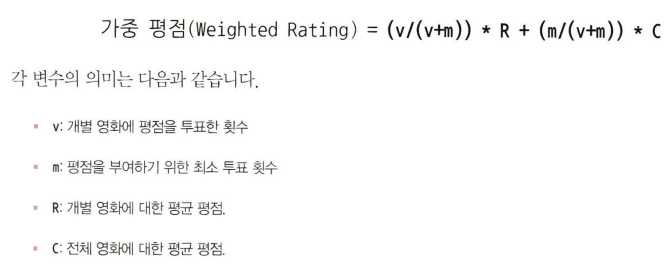

- V : 'vote_count'
- R: 'vote_average'
- C : ['vote_average'].mean()
- m : by quantiile()

In [22]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:', round(C, 3), 'm:', round(m, 3))

C: 6.092 m: 370.2


In [32]:
# 새로운 가중 평점으로 변경하는 함수 생성
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
  v = record['vote_count']
  R = record['vote_average']

  return ( (v/(v+m) * R) + ((m/(m+v))) * C)

movies_df['weighted_vote'] = movies.apply(weighted_vote_average, axis=1)

In [33]:
movies_df[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values('weighted_vote', ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


In [35]:
# 대부와 유사한 영화를 콘텐츠 기반 필터링 방식으로
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  title_movie = df[df['title'] == title_name]
  title_index = title_movie.index.values

  # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes = sorted_ind[title_index, :(top_n*2)]
  similar_indexes = similar_indexes.reshape(-1)
  # 기준 영화 인덱스는 제외
  similar_indexes = similar_indexes[similar_indexes != title_index]

  #top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

## 이전에 추천된 영화보다 훨씬 나은 영화가 추천

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
1149,American Hustle,6.8,6.717525
2582,The Place Beyond the Pines,6.8,6.670483
1243,Mean Streets,7.2,6.626569
1370,21,6.5,6.413490
